In [18]:
import astra
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
angles = loadmat("tiltangles.mat")['tiltdegrees']
print(angles.shape)
#print(angles)

(70, 1)


In [27]:
#tilts the projections in xy axis - Useful for in plane rotation
proj = loadmat('images')
proj["stackNorm"] = rotate(proj["stackNorm"], -2.2, axes=(0, 1), reshape=False)
angles = loadmat("tiltangles.mat")['tiltdegrees']
#print(proj.shape)
#savemat('images_-2.2deg.mat', proj)

In [19]:
def calc_projections(recon, angles, save_path, visualize=False):
    # calculates and extracts the projections from a given reconstruction at each tilt angle in angles
    new_projections = np.zeros((450,450,70))
    #print(recon.shape)
    for index, angle in enumerate(angles): 
        
        angle = angle.item() #check it is a float
        #print(angle)
        # rotate by angle in yz plane
        recon_rotate = rotate(recon, -angle, axes=(0, 2), reshape=False)
        #check new shape
        nx,ny,nz = recon_rotate.shape
        #create empty data shape for new projections
        new_proj = np.zeros((ny,nz))
        #sum along x axis in this new orientation 
        new_proj = np.sum(recon_rotate, axis=0)
        #add this to the other projections 
        new_projections[:,:,index] = new_proj
    np.save(save_path, new_projections) 
    if visualize:
        plt.imshow(new_projections[:,:,35])
        plt.show()
#rotate 0,1  + or - 2.2

In [22]:
# this cell extracts projections from a group of different reconstructions 

angles = loadmat("tiltangles.mat")['tiltdegrees']

for num_iter in range(15,20,5):
    # reconstruction file
    load_file = os.path.expandvars(f"$PSCRATCH/astra_test_iterations/Reconstructions_CGLS/astra_recon5_{num_iter}iter.npy")
    # Calculated projections file
    save_path = os.path.expandvars(f"$PSCRATCH/astra_test_iterations/CalcProjections_CGLS/astra_proj5_{num_iter}iter.npy")
    recon = np.load(load_file)
    
    print(f"extracting projections from {num_iter} iteration reconstruction")
    # ~8 minutes to extract projections from one reconstruction 
    calc_projections(recon, angles, save_path)

extracting projections from 15 iteration reconstruction


In [20]:
def mse_proj_diff(projections_calc, projections_exp, n_proj,visualize=True):
    # mean square error for one projection, n_proj is the number projection it calculates for 
    # visualize allows a graph to be displayed with the pixel by pixel error
    
    #calculate difference between projections (experimental and calculated)
    projections_diff = projections_exp[:,:,n_proj]- projections_calc[:,:,n_proj]
    
    #calculate mean squared error
    squared_differences = projections_diff ** 2
    sum_squared_differences = np.sum(squared_differences)
    num_elements = projections_exp[:,:,n_proj].size
    mse = sum_squared_differences / num_elements
    if visualize:  
        plt.suptitle('Difference Plot', fontsize=18, y=1.02) #Title 
        plt.title(f"mean squared error: {round(mse,4)}", fontsize=12, loc='center')# subtitle (title)
        plt.imshow(projections_diff, cmap='coolwarm')
        plt.colorbar(label='Difference between projections')
        plt.show()
        
    return mse

# n_proj = 35 # which projection to find mse for    
# # calculated projections and rotate to correct orientation
# projections_calc = np.load("astra_recon4_projections_zx_minusangles.npy")
# projections_calc = np.rot90(projections_calc, k=-1, axes=(0, 1))
# # experimental projections 
# projections_exp = loadmat('images')["stackNorm"]

# #run function 
# mse_proj_diff(projections_calc, projections_exp, n_proj, visualize=True)

In [21]:
def calc_total_mse(projections_calc, projections_exp):
    # uses mse_proj_diff to calcualte a total mse for all projections extracted from a single reconstruction 
    nx,ny,nz = projections_exp.shape
    total_mse = 0
    for n_proj in range(nz):
        total_mse += mse_proj_diff(projections_calc, projections_exp, n_proj,visualize=False)

    return total_mse

# calc_total_mse(projections_calc, projections_exp)

In [10]:
# Cell under this is more flexible (doesn't rely on iteration number)

# run to calculate the MSE for each iteration in a file group (to be graphed)
# folder_list = ["2.2tilt", "CGLS", "SIRT_Blur", "CGLS_Blur"]
folder_list = ["2.2tilt", "CGLS"]
all_mse_vs_iteration = []
for recon_type in folder_list:
    mse_vs_iteration = []
    iterations = []
    projections_exp = loadmat('images_-2.2deg')["stackNorm"] # experimental projections
    for i in range(150,600,50): # run mean square error on all iteration numbers
        name = os.path.expandvars(f"$PSCRATCH/astra_test_iterations/CalcProjections_{recon_type}/astra_proj5_{i}iter.npy")
        projections_calc = np.load(name)
        projections_calc = np.rot90(projections_calc, k=-1, axes=(0, 1))
    
        mse_vs_iteration.append(calc_total_mse(projections_calc, projections_exp))
        iterations.append(i)
    # for i in range(250,375,25): # run mean square error on all iteration numbers
    #     name = f"astra_test_iterations/CalcProjections/astra_proj5_{i}iter.npy"
    #     projections_calc = np.load(name)
    #     projections_calc = np.rot90(projections_calc, k=-1, axes=(0, 1))
    
        mse_vs_iteration.append(calc_total_mse(projections_calc, projections_exp))
        iterations.append(i)
    #print(mse_vs_iteration)
    all_mse_vs_iteration.append([iterations,mse_vs_iteration])

In [23]:
# run to calculate the MSE for each iteration in a file group (to be graphed) 
# ** Adjusted to iterate through all files in each folder rather than using the iteration number **

folder_list = ["2.2tilt", "CGLS", "SIRT_Blur"]
all_mse_vs_iteration = []

for recon_type in folder_list:
    mse_vs_iteration = []
    iterations = []

    folder_path = os.path.expandvars(
        f"$PSCRATCH/astra_test_iterations/CalcProjections_{recon_type}/"
    )
    projections_exp = loadmat('images_-2.2deg')["stackNorm"]

    # Collect matching files + iteration numbers
    files = []
    for name in os.listdir(folder_path):
        match = re.search(r'_(\d+)iter\.npy$', name)
        if match:
            iter_number = int(match.group(1))
            files.append((iter_number, name))

    # Sort files by iteration number
    files.sort(key=lambda x: x[0])

    # Loop in sorted order
    for iter_number, name in files:
        full_path = os.path.join(folder_path, name)

        projections_calc = np.load(full_path)
        projections_calc = np.rot90(projections_calc, k=-1, axes=(0, 1))

        mse_vals = calc_total_mse(projections_calc, projections_exp)

        iterations.append(iter_number)
        mse_vs_iteration.append(mse_vals)

    all_mse_vs_iteration.append([iterations, mse_vs_iteration])

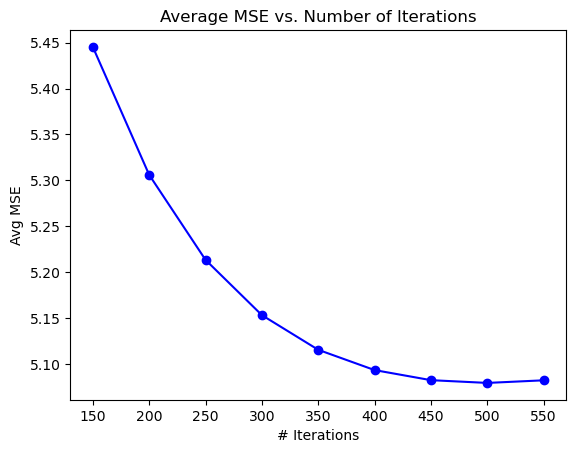

In [24]:
iterations, mse_vs_iteration = all_mse_vs_iteration[2]
plt.plot(iterations, mse_vs_iteration, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('# Iterations')
plt.ylabel('Avg MSE')
plt.title('Average MSE vs. Number of Iterations')

# Show the plot
plt.show()

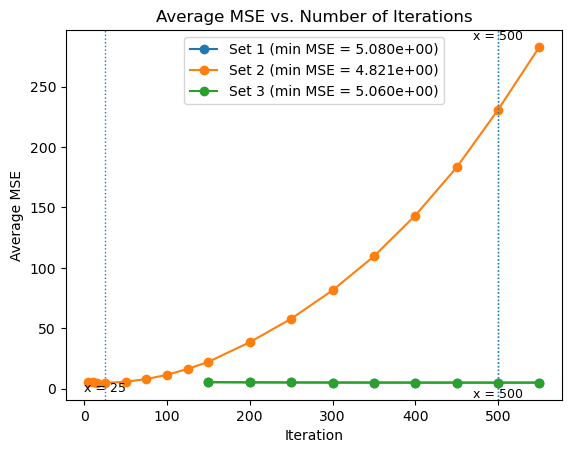

In [25]:
data = [all_mse_vs_iteration[0],all_mse_vs_iteration[1], all_mse_vs_iteration[2]]

plt.figure()

for i, (x_vals, y_vals) in enumerate(data):

    # --- Find minimum ---
    min_idx = np.argmin(y_vals)
    min_x = x_vals[min_idx]
    min_y = y_vals[min_idx]

    # --- Dotted vertical line at minimum iteration ---
    plt.axvline(min_x, linestyle=':', linewidth=1)

    # --- Display the x-value above the dotted line ---
    plt.text(
        min_x, 
        plt.ylim()[1],       # place at the top of plot
        f"x = {min_x}",
        ha='center',
        va='top',
        fontsize=9
    )

    # --- Plot curve with min MSE shown in legend ---
    plt.plot(
        x_vals, 
        y_vals,
        marker='o',
        linestyle='-',
        label=f"Set {i+1} (min MSE = {min_y:.3e})"
    )

# Labels and title
plt.xlabel('Iteration')
plt.ylabel('Average MSE')
plt.title('Average MSE vs. Number of Iterations')

plt.legend()
plt.show()